In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence-transformers -q

In [3]:
import os
import numpy as np
import pandas as pd

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.sparse import hstack, csr_matrix

In [43]:
from scipy.sparse import load_npz, save_npz
import gc

In [5]:
# --- 1. Paths ---
BASE_PATH = "/content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource"
EMBEDDINGS_DIR = os.path.join(BASE_PATH, 'embeddings')
DATASET_FOLDER = os.path.join(BASE_PATH, 'dataset/')
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

In [6]:
df_train['price'].value_counts().head(10)

,count
price,
14.99,918
9.99,881
19.99,687
12.99,634
8.99,519
7.99,514
13.99,496
11.99,458
16.99,454


In [7]:
df_train = df_train.drop('image_link', axis=1)
df_test = df_test.drop('image_link', axis=1)

In [8]:
df_test.head()

,sample_id,catalog_content
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...
1,245611,Item Name: Natural MILK TEA Flavoring extract ...
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...
4,36806,"Item Name: McCormick Culinary Vanilla Extract,..."


In [9]:
# First, create the log-transformed price
df_train['price_log'] = np.log1p(df_train['price'])

In [10]:
df_train.head()

,sample_id,catalog_content,price,price_log
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.89,1.773256
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.12,2.647592
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.97,1.088562
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.34,3.444895
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.49,4.211979


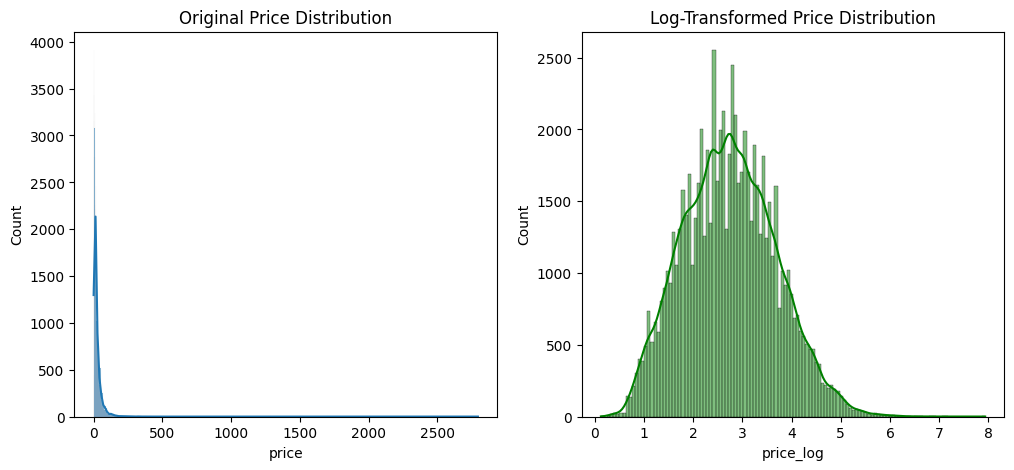

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original price distribution
sns.histplot(df_train['price'], ax=axes[0], kde=True)
axes[0].set_title('Original Price Distribution')

# Plot log-transformed price distribution
sns.histplot(df_train['price_log'], ax=axes[1], kde=True, color='green')
axes[1].set_title('Log-Transformed Price Distribution')

plt.show()

In [12]:
df_train['catalog_content'][2]

'Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet Point 1: Loaded with hearty long grain wild rice and vegetables\nBullet Point 2: Full of hearty goodness\nBullet Point 3: Single serve bowls\nBullet Point 4: Easy to prepare mix\nBullet Point 5: 0 grams trans fat\nValue: 11.4\nUnit: Ounce\n'

In [13]:
def parse_catalog_content(text):
    if not isinstance(text, str):
        return pd.Series({'item_name': '', 'bullet_points': '', 'ipq_value': 0.0, 'ipq_unit': 'unknown'})

    name = re.search(r"Item Name: (.*?)(?=\nBullet Point|\nValue:|$)", text, re.DOTALL)
    bullets = re.findall(r"Bullet Point \d+: (.*?)(?=\nBullet Point|\nValue:|$)", text, re.DOTALL)
    value = re.search(r"Value: ([\d.]+)", text)
    unit = re.search(r"Unit: ([\w\s]+)", text)

    return pd.Series({
        'item_name': name.group(1).strip() if name else '',
        'bullet_points': " ".join([b.strip() for b in bullets]) if bullets else '',
        'ipq_value': float(value.group(1)) if value else 0.0,
        'ipq_unit': unit.group(1).strip() if unit else 'unknown'
    })

In [14]:
print("🔹 Parsing catalog_content...")
for df in [df_train, df_test]:
    features = df['catalog_content'].apply(parse_catalog_content)
    df[['item_name', 'bullet_points', 'ipq_value', 'ipq_unit']] = features

🔹 Parsing catalog_content...


In [15]:
df_train.head(10)

,sample_id,catalog_content,price,price_log,item_name,bullet_points,ipq_value,ipq_unit
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.89,1.773256,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",,72.00,Fl Oz
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.12,2.647592,"Salerno Cookies, The Original Butter Cookies, ...",Original Butter Cookies: Classic butter cookie...,32.00,Ounce
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.97,1.088562,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",Loaded with hearty long grain wild rice and ve...,11.40,Ounce
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.34,3.444895,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,"Add to your favorite appetizers, dips & spread...",11.25,Ounce
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.49,4.211979,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",,12.00,Count
5,9259,"Item Name: Member's Mark Member's Mark, Basil,...",18.50,2.970414,"Member's Mark Member's Mark, Basil, 6.25 oz","Green Herb, Italian Staple, Great mixed with O...",6.25,ounce
6,191846,Item Name: Goya Foods Sazonador Total Seasonin...,5.99,1.944481,"Goya Foods Sazonador Total Seasoning, 30 Ounce...",SAZONADOR TOTAL | Enhance the natural flavors ...,180.00,Ounce
7,222007,Item Name: VineCo Original Series Chilean Sauv...,94.00,4.553877,VineCo Original Series Chilean Sauvignon Blanc...,Chilean Sauvignon Blanc Wine Kit - VineCo Orig...,1.00,Count
8,37614,Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...,35.74,3.603866,"NATURES PATH CEREAL FLK MULTIGRAIN ORG ECO, 32...",,192.00,Fl Oz
9,238044,Item Name: Mrs. Miller's Seedless Black Raspbe...,31.80,3.490429,Mrs. Miller's Seedless Black Raspberry Jam 9 O...,Homemade Seedless Black Raspberry Jam made fro...,9.00,Ounce


In [16]:
df_train['catalog_content'][7]

'Item Name: VineCo Original Series Chilean Sauvignon Blanc Wine Making Ingredient Kit\nBullet Point 1: Chilean Sauvignon Blanc Wine Kit - VineCo Original Series\nBullet Point 2: Flavor Profile - Herbaceous, stone fruit and tropical fruit\nBullet Point 3: Kit Volume: 8 L, Approximate Yield: 23 L\nBullet Point 4: Ready to Bottle: In 4 weeks\nBullet Point 5: Ingredient Kit Only Does Not Contain Alcohol\nProduct Description: Chilean Sauvignon Blanc Wine Kit - VineCo Original Series - Unleash the Refreshing Essence of Sauvignon Blanc Known for its vibrant personality, Sauvignon Blanc is a green-skinned grape that embodies the wild spirit of nature. Its name is derived from the French term for "wild," reflecting its unrestrained growth and bold flavors. This grape variety thrives in diverse climates, producing wines that range from crisp and herbaceous to tropical and fruity. In cooler regions, you can expect wines to showcase a lively acidity with green bell pepper and grassy notes, while w

In [17]:
df_train['bullet_points'][7]

'Chilean Sauvignon Blanc Wine Kit - VineCo Original Series Flavor Profile - Herbaceous, stone fruit and tropical fruit Kit Volume: 8 L, Approximate Yield: 23 L Ready to Bottle: In 4 weeks Ingredient Kit Only Does Not Contain Alcohol\nProduct Description: Chilean Sauvignon Blanc Wine Kit - VineCo Original Series - Unleash the Refreshing Essence of Sauvignon Blanc Known for its vibrant personality, Sauvignon Blanc is a green-skinned grape that embodies the wild spirit of nature. Its name is derived from the French term for "wild," reflecting its unrestrained growth and bold flavors. This grape variety thrives in diverse climates, producing wines that range from crisp and herbaceous to tropical and fruity. In cooler regions, you can expect wines to showcase a lively acidity with green bell pepper and grassy notes, while warmer areas enhance the fruit profile, leading to delightful tropical flavors. Chilean Sauvignon Blanc is particularly celebrated for its citrusy brightness, moving away 

In [18]:
df_train['ipq_unit'].unique()

array(['Fl Oz', 'Ounce', 'Count', 'ounce', 'None', 'Fluid Ounce', 'count',
       'oz', 'Ounces', 'pound', 'fl oz', 'gram', 'grams', 'COUNT',
       'FL Oz', 'lb', 'Each', 'Liters', 'gramm', 'ct', 'Pound', 'Oz',
       'OZ', 'millilitre', 'Jar', 'ounces', 'Fl', 'bottle', 'Bottle',
       'Gram', 'Can', 'Tea Bags', 'Fl oz', 'each', '20 oz', '24', 'Pack',
       'Piece', 'fluid ounces', 'gr', 'milliliter', 'mililitro', 'CT',
       '2', 'FL OZ', 'pack', 'pounds', 'kg', 'Bag', 'in', 'fl', 'K',
       'fluid ounce', 'sq ft', 'unknown', 'ml', 'Packs', 'box', '8',
       'Fl Ounce', 'Pouch', 'Bucket', 'LB', 'per Box', 'Per Package',
       '1 PK', 'Comes as a single 0', 'units', 'CASE\nBullet Point 2',
       'packs', 'BOX', '1', 'Fluid Ounces', 'product_weight', 'Sq Ft',
       'per Carton', 'Foot', 'Grams', 'Box', 'unità',
       'Paper Cupcake Liners', 'capsule', 'bottles', 'bag', '', 'Pounds',
       'Ziplock bags', 'Fluid ounce', 'ltr', 'PACK', 'can', 'Carton',
       'Tea bags', '7'], 

In [19]:
print(df_train['ipq_unit'].value_counts().head(50))

ipq_unit
Ounce           40983
Count           17452
Fl Oz           11082
ounce            1960
oz                962
None              940
count             741
pound             158
fl oz             128
Oz                 78
ct                 46
Pound              44
lb                 30
Fluid Ounce        30
FL Oz              28
OZ                 24
Fl                 22
gram               20
Gram               19
COUNT              16
FL OZ              15
ounces             14
each               14
Each               12
packs              11
millilitre          9
fluid ounces        8
fluid ounce         8
Liters              7
gramm               6
Ounces              6
kg                  6
Fluid Ounces        6
bottle              6
Pack                6
Can                 5
Bag                 5
Jar                 4
Fl oz               4
LB                  4
Bottle              3
grams               3
pounds              3
milliliter          3
Piece               3
K

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
def normalize_units_robust(df):
    """
    Cleans all messy unit strings using a comprehensive map, creates new normalized columns,
    and applies the correct numerical conversions.
    """
    df_copy = df.copy()

    # Create the new columns to store the clean data
    df_copy['ipq_value_normalized'] = df_copy['ipq_value']

    # --- Step 1: Define the Final, Complete, Lowercase UNIT_MAP ---
    # This is the single source of truth for all unit handling.
    UNIT_MAP = {
      # Weight -> gram
      "ounce": "gram", "ounces": "gram", "oz": "gram", "fl ounce": "gram",
      "pound": "gram", "pounds": "gram", "lb": "gram",
      "gram": "gram", "grams": "gram", "gramm": "gram", "gr": "gram",
      "kg": "gram", "product_weight": "gram",

      # Volume -> ml
      "fl oz": "ml", "fluid ounce": "ml", "fluid ounces": "ml", "fl": "ml",
      "liter": "ml", "liters": "ml", "ltr": "ml",
      "millilitre": "ml", "milliliter": "ml", "mililitro": "ml", "ml": "ml",

      # Count -> count
      "count": "count", "ct": "count", "each": "count", "pack": "count",
      "packs": "count", "pk": "count", "piece": "count", "units": "count",
      "jar": "count", "can": "count", "bottle": "count", "bottles": "count",
      "bag": "count", "box": "count", "pouch": "count", "bucket": "count",
      "carton": "count", "capsule": "count", "tea bags": "count",
      "per box": "count", "per package": "count", "per carton": "count",
      "unità": "count", 'paper cupcake liners': 'count', 'ziplock bags': 'count',

      # Other / Ambiguous -> other
      "none": "other", "unknown": "other", "in": "other",
      "sq ft": "other", "foot": "other", "k": "other", "": "other",
      "20 oz": "other", "24": "other", "2": "other", "8": "other", "1": "other", "7": "other",
      "comes as a single 0": "other", "case\nbullet point 2": "other"
    }

    # --- Step 2: Create the clean 'ipq_unit_base' column ---
    # Use the original ipq_unit, converted to lowercase, for mapping
    original_unit_lower = df_copy['ipq_unit'].str.lower()
    df_copy['ipq_unit_base'] = original_unit_lower.map(UNIT_MAP).fillna('other')

    # --- Step 3: Apply numerical conversions to 'ipq_value_normalized' ---
    # Conversion factors
    oz_to_g = 28.3495
    lb_to_g = 453.592
    kg_to_g = 1000.0
    floz_to_ml = 29.5735
    l_to_ml = 1000.0

    # Use the original lowercase unit string to find which conversion to apply
    # This ensures all variations (e.g., "Ounce", "ounce", "oz") are handled correctly.
    df_copy.loc[original_unit_lower.isin(['ounce', 'ounces', 'oz', 'fl ounce']), 'ipq_value_normalized'] *= oz_to_g
    df_copy.loc[original_unit_lower.isin(['pound', 'pounds', 'lb']), 'ipq_value_normalized'] *= lb_to_g
    df_copy.loc[original_unit_lower.isin(['kg']), 'ipq_value_normalized'] *= kg_to_g

    df_copy.loc[original_unit_lower.isin(['fl oz', 'fluid ounce', 'fluid ounces', 'fl']), 'ipq_value_normalized'] *= floz_to_ml
    df_copy.loc[original_unit_lower.isin(['liter', 'liters', 'ltr']), 'ipq_value_normalized'] *= l_to_ml

    return df_copy

In [22]:
# --- EXECUTION ---
print("🔹 Normalizing IPQ units and values into new columns...")
df_train = normalize_units_robust(df_train)
df_test = normalize_units_robust(df_test)

🔹 Normalizing IPQ units and values into new columns...


In [23]:
df_train.head()

,sample_id,catalog_content,price,price_log,item_name,bullet_points,ipq_value,ipq_unit,ipq_value_normalized,ipq_unit_base
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.89,1.773256,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",,72.00,Fl Oz,2129.292000,ml
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.12,2.647592,"Salerno Cookies, The Original Butter Cookies, ...",Original Butter Cookies: Classic butter cookie...,32.00,Ounce,907.184000,gram
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.97,1.088562,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",Loaded with hearty long grain wild rice and ve...,11.40,Ounce,323.184300,gram
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.34,3.444895,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,"Add to your favorite appetizers, dips & spread...",11.25,Ounce,318.931875,gram
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.49,4.211979,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",,12.00,Count,12.000000,count


In [24]:
# --- Final Scaling of the new normalized IPQ Value ---
scaler = StandardScaler()
df_train['ipq_value_scaled'] = scaler.fit_transform(df_train['ipq_value_normalized'].values.reshape(-1, 1))
df_test['ipq_value_scaled'] = scaler.transform(df_test['ipq_value_normalized'].values.reshape(-1, 1))

In [25]:
df_train.head()

,sample_id,catalog_content,price,price_log,item_name,bullet_points,ipq_value,ipq_unit,ipq_value_normalized,ipq_unit_base,ipq_value_scaled
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.89,1.773256,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",,72.00,Fl Oz,2129.292000,ml,0.074257
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.12,2.647592,"Salerno Cookies, The Original Butter Cookies, ...",Original Butter Cookies: Classic butter cookie...,32.00,Ounce,907.184000,gram,-0.028138
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.97,1.088562,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",Loaded with hearty long grain wild rice and ve...,11.40,Ounce,323.184300,gram,-0.077069
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.34,3.444895,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,"Add to your favorite appetizers, dips & spread...",11.25,Ounce,318.931875,gram,-0.077426
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.49,4.211979,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",,12.00,Count,12.000000,count,-0.103142


In [26]:
df_test.head()

,sample_id,catalog_content,item_name,bullet_points,ipq_value,ipq_unit,ipq_value_normalized,ipq_unit_base,ipq_value_scaled
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,You'll LOVE our 14-Spice Eshamaya's Mango Chut...,10.5,Ounce,297.66975,gram,-0.079207
1,245611,Item Name: Natural MILK TEA Flavoring extract ...,Natural MILK TEA Flavoring extract by HALO PAN...,"Authentic Tasting, Asian-Inspired Natural flav...",2.0,Fl Oz,59.14700,ml,-0.099192
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...,Honey Filled Hard Candy - Bulk Pack 2 Pounds -...,Honey Filled Hard Candy; 2-pound bulk pack; ap...,32.0,Ounce,907.18400,gram,-0.028138
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,Vlasic Snack'mm's Kosher Dill 16 Oz (Pack of 2),,2.0,Count,2.00000,count,-0.103980
4,36806,"Item Name: McCormick Culinary Vanilla Extract,...","McCormick Culinary Vanilla Extract, 32 fl oz -...",PREMIUM INGREDIENTS: McCormick Culinary Pure V...,32.0,Fl Oz,946.35200,ml,-0.024857


In [27]:
df_test['ipq_unit_base'].unique()

array(['gram', 'ml', 'count', 'other'], dtype=object)

In [28]:
df_train['ipq_unit_base'].value_counts()

,count
ipq_unit_base,
gram,44327
count,18355
ml,11356
other,962


In [29]:
# 1. Load the existing combined sparse features (Base + 3 k-NN)
# These files were saved in your previous 'Final Cleanup and Stacking' step.
print("   - Loading existing combined sparse features (Base + kNN)...")
X_train_final_base = load_npz(os.path.join(EMBEDDINGS_DIR, 'X_train_final_sparse.npz'))
X_test_final_base = load_npz(os.path.join(EMBEDDINGS_DIR, 'X_test_final_sparse.npz'))
print(f"   - Base Train Shape: {X_train_final_base.shape}")

   - Loading existing combined sparse features (Base + kNN)...
   - Base Train Shape: (75000, 7539)


In [30]:
# 2. Extract the scaled IPQ feature (Strategy 2)
# These columns are ready because you confirmed 'ipq_value_scaled' is in df_train/df_test.
ipq_train_scaled = df_train['ipq_value_scaled'].values.reshape(-1, 1)
ipq_test_scaled = df_test['ipq_value_scaled'].values.reshape(-1, 1)
print("   - IPQ feature extracted.")

   - IPQ feature extracted.


In [31]:
# 3. Stack the IPQ feature onto the existing matrix
print("🔹 Stacking the scaled IPQ feature...")

# Convert IPQ (dense numpy array) to sparse CSR matrix
ipq_train_sparse = csr_matrix(ipq_train_scaled)

🔹 Stacking the scaled IPQ feature...


In [32]:
ipq_test_sparse = csr_matrix(ipq_test_scaled)

In [37]:
gc.collect()

0

In [35]:
# Perform horizontal stacking: [Base + kNN | IPQ]
X_train_final = hstack([X_train_final_base, ipq_train_sparse], format='csr')

In [36]:
del X_train_final_base, ipq_train_sparse
gc.collect()

104

In [38]:
X_test_final = hstack([X_test_final_base, ipq_test_sparse], format='csr')

In [39]:
del X_test_final_base, ipq_test_sparse
gc.collect()

0

In [40]:
print(f"✅ Final Train Shape (Base + kNN + IPQ): {X_train_final.shape}")
print(f"✅ Final Test Shape (Base + kNN + IPQ): {X_test_final.shape}")

✅ Final Train Shape (Base + kNN + IPQ): (75000, 7540)
✅ Final Test Shape (Base + kNN + IPQ): (75000, 7540)


In [41]:
# 4. Final Preparation for LightGBM
y_train = np.log1p(df_train['price']).values
print("✅ Target variable y_train (log-price) ready.")

✅ Target variable y_train (log-price) ready.


In [44]:
# 5. Save the new matrix for persistence (Highly Recommended)
print("🔹 Saving the new combined feature matrix (Base + kNN + IPQ)...")
save_npz(os.path.join(EMBEDDINGS_DIR, 'X_train_final_ipq_sparse.npz'), X_train_final)
save_npz(os.path.join(EMBEDDINGS_DIR, 'X_test_final_ipq_sparse.npz'), X_test_final)
print("✅ New matrices saved to disk for Strategy 2.")

🔹 Saving the new combined feature matrix (Base + kNN + IPQ)...
✅ New matrices saved to disk for Strategy 2.


In [46]:
del ipq_train_scaled, ipq_test_scaled
gc.collect()

143

In [47]:
X_train_final.shape

(75000, 7540)

In [49]:
df_train.head()

,sample_id,catalog_content,price,price_log,item_name,bullet_points,ipq_value,ipq_unit,ipq_value_normalized,ipq_unit_base,ipq_value_scaled
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.89,1.773256,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",,72.00,Fl Oz,2129.292000,ml,0.074257
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.12,2.647592,"Salerno Cookies, The Original Butter Cookies, ...",Original Butter Cookies: Classic butter cookie...,32.00,Ounce,907.184000,gram,-0.028138
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.97,1.088562,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",Loaded with hearty long grain wild rice and ve...,11.40,Ounce,323.184300,gram,-0.077069
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.34,3.444895,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,"Add to your favorite appetizers, dips & spread...",11.25,Ounce,318.931875,gram,-0.077426
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.49,4.211979,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",,12.00,Count,12.000000,count,-0.103142


In [51]:
print(y_train[:5])

[1.773256   2.64759223 1.08856195 3.44489524 4.21197944]


In [52]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [53]:
# !pip install lightgbm -q
# Define a function to calculate SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

print("🔹 Starting 5-Fold Cross-Validation with LightGBM...")

🔹 Starting 5-Fold Cross-Validation with LightGBM...


In [82]:
# Configuration
N_SPLITS = 5
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_predictions = np.zeros(y_train.shape[0])
test_predictions = np.zeros(df_test.shape[0])

# LightGBM Parameters (Optimized for speed and regression)
# 'metric': 'rmse' is standard for log-transformed target variables.
lgbm_params_fast = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.075,       # can stay
    'n_estimators': 1000,         # 🔹 reduce 10x
    'num_leaves': 80,            # 🔹 smaller trees
    'max_depth': 10,             # 🔹 limit tree depth
    'min_child_samples': 20,
    'min_gain_to_split': 0.0,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'colsample_bytree': 0.6,     # subsample columns
    'subsample': 0.6,            # subsample rows
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'verbosity': -1,
    'seed': 42
}

In [83]:
print(f"Number of nonzero entries: {X_train_final.nnz}")
print(f"Average nonzeros per sample: {X_train_final.nnz / X_train_final.shape[0]:.2f}")

Number of nonzero entries: 119653037
Average nonzeros per sample: 1595.37


In [84]:
from tqdm import tqdm

In [85]:
gc.collect()

430

In [86]:
# --- 2. Training loop with progress ---
oof_predictions = np.zeros(y_train.shape[0])
test_predictions = np.zeros(df_test.shape[0])

In [87]:
gc.collect()

0

In [88]:
# --- 1. The Optimized Training Loop ---
for fold, (train_index, val_index) in enumerate(tqdm(KF.split(X_train_final, y_train), total=N_SPLITS, desc="Folds")):
    print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")

    # Slicing the sparse matrix is efficient
    X_train_fold = X_train_final[train_index]
    X_val_fold = X_train_final[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # LightGBM handles sparse data natively and efficiently
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_val = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train)

    # Train the model
    model = lgb.train(
        lgbm_params_fast,
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=10)] # You will see output now
    )

    # Predict OOF and Test
    val_preds = model.predict(X_val_fold)
    oof_predictions[val_index] = val_preds
    test_predictions += model.predict(X_test_final) / N_SPLITS

    rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
    print(f"Fold {fold+1} RMSE (log-price): {rmse:.4f}")

    del model, lgb_train, lgb_val, X_train_fold, X_val_fold, y_train_fold, y_val_fold, val_preds
    gc.collect()

Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.680657


Folds:   0%|          | 0/5 [21:12<?, ?it/s]


KeyboardInterrupt: 

In [61]:
print("\n====================================")
# Revert predictions from log-price to actual price
y_true_price = np.expm1(y_train)
oof_price_preds = np.expm1(oof_predictions)
final_test_price_preds = np.expm1(test_predictions)

# Clip predictions to ensure positivity
oof_price_preds[oof_price_preds < 0] = 0
final_test_price_preds[final_test_price_preds < 0] = 0

# Calculate final SMAPE on the OOF predictions
final_smape = smape(y_true_price, oof_price_preds)

print(f"✅ Final OOF SMAPE Score: {final_smape:.4f}%")
print("====================================")


✅ Final OOF SMAPE Score: 50.4499%


In [ ]:
# --- Create Submission File (No Snapping) ---
submission_df_no_snap = pd.DataFrame({
    'sample_id': df_test['sample_id'],
    'price': final_test_price_preds
})

# Define submission path
SUBMISSION_PATH_NO_SNAP = os.path.join(BASE_PATH, 'submission_5.csv')
submission_df_no_snap.to_csv(SUBMISSION_PATH_NO_SNAP, index=False)

print(f"🚀 Submission file (No Snapping) created successfully at: {SUBMISSION_PATH_NO_SNAP}")
print(f"Submission DataFrame shape: {submission_df_no_snap.shape}")

🚀 Submission file created successfully at: /content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource/submission2.csv


(75000, 2)

In [62]:
def snap_to_retail_price(price):
    # 1. Safety Check: Ensure the price is positive.
    if price <= 0.01:
        return 0.01

    integer_part = int(price)

    # 2. Define Endings from Training Data Analysis (Top 8 most frequent)
    endings = [0.99, 0.49, 0.98, 0.95, 0.00, 0.79, 0.29, 0.50]

    # 3. Generate Candidate Snap Prices (in current and lower integer ranges)

    # Candidate snaps in the CURRENT integer range (e.g., 10.XX to 10.99)
    current_integer_snaps = [integer_part + e for e in endings]

    # Candidate snaps in the NEXT LOWER integer range (e.g., 10.XX to 9.99)
    lower_integer_snaps = []
    if integer_part > 0:
        # Only check the lower block if the price is > 1.00
        lower_integer_snaps = [integer_part - 1 + e for e in endings]

    # Combine all possible snap prices
    candidate_prices = current_integer_snaps + lower_integer_snaps

    # 4. Find the candidate that minimizes the absolute difference from the predicted price
    # This ensures snapping to the *closest* point, correcting bias implicitly.
    closest_snapped_price = min(candidate_prices, key=lambda x: abs(x - price))

    # 5. Final Safety Check and Rounding
    # Ensure it's not negative and round to 2 decimal places.
    return max(0.01, round(closest_snapped_price, 2))

In [63]:
# Assuming test_preds_log and df_test are available from the LightGBM run

print("🔹 Applying price snapping post-processing...")

# Convert predictions back to dollar amounts
final_predictions = np.expm1(test_predictions)
final_predictions[final_predictions < 0] = 0 # Ensure no negative prices

# Apply the snapping function
snapped_predictions = [snap_to_retail_price(p) for p in final_predictions]

🔹 Applying price snapping post-processing...


In [64]:
# --- Create Submission File (With Snapping) ---
submission_df_snap = pd.DataFrame({'sample_id': df_test['sample_id'], 'price': snapped_predictions})
submission_path_snap = os.path.join(BASE_PATH, "submission_snapped5.csv")
submission_df_snap.to_csv(submission_path_snap, index=False)

print(f"\n💾 Submission file (Snapped) saved to: {submission_path_snap}")
print("--- Sample Snapped Predictions ---")
print(submission_df_snap.head())
print(f"Submission DataFrame shape: {submission_df_snap.shape}")


💾 Submission file (Snapped) saved to: /content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource/submission_snapped5.csv
--- Sample Snapped Predictions ---
   sample_id  price
0     100179  14.79
1     245611  13.95
2     146263  21.50
3      95658  14.79
4      36806  30.95
Submission DataFrame shape: (75000, 2)


In [65]:
submission_df_snap.shape

(75000, 2)

In [ ]:
df_train['price'].unique().head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [91]:
gc.collect()

0

In [92]:
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import gc

# Assuming X_train_final, X_test_final, y_train_log, df_test, and test_predictions are available

print("🔹 Training Final 100% Model (Using Stable LR)...")

# --- Final Optimized Parameters for the 100% Model ---
lgbm_params_fast = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.075,       # can stay
    'n_estimators': 1000,         # 🔹 reduce 10x
    'num_leaves': 80,            # 🔹 smaller trees
    'max_depth': 10,             # 🔹 limit tree depth
    'min_child_samples': 20,
    'min_gain_to_split': 0.0,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'colsample_bytree': 0.6,     # subsample columns
    'subsample': 0.6,            # subsample rows
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'verbosity': -1,
    'seed': 42
}

# Initialize and train on 100% of the training data
final_model_100 = lgb.LGBMRegressor(**lgbm_params_fast)
final_model_100.fit(X_train_final, y_train)

# Predict on the test set using this single model
final_preds_100 = final_model_100.predict(X_test_final)

print("✅ Final 100% Model Training Complete.")

🔹 Training Final 100% Model (Using Stable LR)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ Final 100% Model Training Complete.


In [104]:
final_preds_100

array([2.78172771, 2.64765062, 3.11540322, 2.60786939, 3.44330434,
       1.82031253, 2.81742397, 3.28929577, 2.904539  , 2.08453665,
       3.16644949, 1.95368916, 3.72798486, 2.48581946, 2.98863463,
       2.47540567, 3.87766657, 2.59668765, 2.47342992, 2.40786418])

In [100]:
!ls "/content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource/"

dataset			   images     sample_code.py   submission.csv
Documentation_template.md  models     src	       submission_snapped5.csv
embeddings		   README.md  submission2.csv


In [101]:
SAVED_SUBMISSION_PATH = os.path.join(BASE_PATH, 'submission_snapped5.csv')
df_old_preds = pd.read_csv(SAVED_SUBMISSION_PATH)

In [105]:
# Convert the new 100% model's LOG predictions back to price for blending
final_preds_100_price = np.expm1(final_preds_100)
final_preds_100_price[final_preds_100_price < 0] = 0

# Merge the two prediction sets based on the unique 'sample_id'
df_test_full = df_test[['sample_id']].copy()
df_test_full['price_100_percent'] = final_preds_100_price

In [106]:
# Merge the two prediction sets based on the unique 'sample_id'
df_merged = pd.merge(
    df_test_full,
    df_old_preds[['sample_id', 'price']],
    on='sample_id',
    suffixes=('_new', '_old')
)

In [109]:
print(df_merged.head(20))

    sample_id  price_100_percent  price
0      100179          15.146894  14.79
1      245611          13.120824  13.95
2      146263          21.542518  21.50
3       95658          12.570107  14.79
4       36806          30.290181  30.95
5      148239           5.173788   5.79
6       92659          15.733689  14.00
7        3780          25.823967  21.79
8      196940          17.256825  17.00
9       20472           7.040865   6.95
10     121721          22.723106  25.95
11     127336           6.054665   6.29
12      20801          40.595203  35.79
13      30103          11.010959   9.00
14      68691          18.858550  19.29
15     230703          10.886528   9.50
16       3342          47.311352  32.99
17     115635          12.419215  12.00
18     221565          10.863067  10.79
19     265927          10.110206  13.29


In [141]:
final_blended_predictions = (
    (df_merged['price_100_percent'] * 0.50) +
    (df_merged['price'] * 0.50)
).values

In [142]:
final_blended_predictions[0:20]

array([14.968447  , 13.53541224, 21.5212591 , 13.68005372, 30.62009042,
        5.48189382, 14.86684435, 23.80698343, 17.12841268,  6.99543242,
       24.3365528 ,  6.17233272, 38.19260171, 10.00547937, 19.07427482,
       10.19326405, 40.15067604, 12.20960762, 10.82653328, 11.70010319])

In [143]:
def snap_to_retail_price(price):
    """
    Snaps a predicted price to the nearest of the most dominant retail endings
    (0.99, 0.49, 0.50, 0.00).
    """
    if price <= 0.01:
        return 0.01

    integer_part = int(price)
    decimal_part = price - integer_part

    # Define the minimal, high-frequency snap points
    endings = [0.00, 0.49, 0.50, 0.99]

    # Generate Candidate Snaps (Current and Lower Dollar)
    current_integer_snaps = [integer_part + e for e in endings]

    lower_integer_snaps = []
    if integer_part > 0:
        # Include a snap-down option to the highly frequent 0.99 threshold
        lower_integer_snaps = [integer_part - 1 + 0.99]

    candidate_prices = current_integer_snaps + lower_integer_snaps

    # Find the absolute closest candidate price
    closest_snapped_price = min(candidate_prices, key=lambda x: abs(x - price))

    # Final Safety Check and Rounding
    return max(0.01, round(closest_snapped_price, 2))

In [144]:
print("🔹 Applying price snapping post-processing...")
snapped_predictions = np.array([snap_to_retail_price(p) for p in final_blended_predictions])

🔹 Applying price snapping post-processing...


In [145]:
snapped_predictions[0:20]

array([14.99, 13.5 , 21.5 , 13.5 , 30.5 ,  5.49, 14.99, 23.99, 17.  ,
        6.99, 24.49,  6.  , 38.  , 10.  , 19.  , 10.  , 40.  , 12.  ,
       10.99, 11.5 ])

In [134]:
pd.set_option('display.max_rows', None)

In [135]:
print(df_train['price'].value_counts())

price
14.990      918
9.990       881
19.990      687
12.990      634
8.990       519
7.990       514
13.990      496
11.990      458
16.990      454
17.990      451
5.990       447
10.990      434
6.990       431
4.990       423
29.990      420
3.990       417
18.990      415
24.990      415
15.990      317
2.990       317
39.990      297
22.990      286
21.990      273
10.000      252
5.490       247
1.990       229
34.990      229
4.490       226
6.490       224
23.990      215
3.490       209
26.990      201
4.790       190
7.490       188
20.990      174
27.990      172
32.990      171
25.990      170
28.990      166
49.990      166
59.990      156
14.950      152
8.490       148
31.990      147
9.980       143
4.290       140
2.490       139
3.790       137
11.980      135
5.290       133
9.490       125
3.980       121
2.980       120
44.990      120
11.490      118
4.980       116
3.290       115
35.990      114
2.790       113
1.980       111
3.690       109
19.950      109
12

In [146]:
submission_df = pd.DataFrame({
    'sample_id': df_test['sample_id'],
    'price': snapped_predictions
})

In [147]:
submission_path = os.path.join(BASE_PATH, "submission_6.csv")
submission_df.to_csv(submission_path, index=False)

In [148]:
print(submission_df.head())

   sample_id  price
0     100179  14.99
1     245611  13.50
2     146263  21.50
3      95658  13.50
4      36806  30.50
